In [0]:
# import necessary packages
import pandas as pd
import numpy as np

import seaborn as sns

import nltk
from nltk.stem import PorterStemmer #for stemming
from nltk.tokenize import word_tokenize
import nltk.corpus

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn import svm

from gensim.models.word2vec import Word2Vec

import matplotlib.pyplot as plt
import pickle

import warnings
warnings.filterwarnings("ignore")

In [0]:
# load all three datasets
trainFile = 'train2.tsv'
testFile = 'test2.tsv'
valFile = 'val2.tsv'

# add header to all three datasets
traindata = pd.read_csv(trainFile, delimiter='\t', encoding='utf-8', names=
                        ["json ID", "label", "statement", "subject", "speaker", "job title", "state", "party",
                         "barely true", "false", "half true", "mostly true", "pants on fire", "los", "justification"])
traindata.name = 'Training Data'

testdata = pd.read_csv(testFile, delimiter='\t', encoding='utf-8', names=
                        ["json ID", "label", "statement", "subject", "speaker", "job title", "state", "party",
                         "barely true", "false", "half true", "mostly true", "pants on fire", "los", "justification"])
testdata.name = 'Testing Data'

valdata = pd.read_csv(valFile, delimiter='\t', encoding='utf-8', names=
                        ["json ID", "label", "statement", "subject", "speaker", "job title", "state", "party",
                         "barely true", "false", "half true", "mostly true", "pants on fire", "los", "justification"])
valdata.name = 'Validation Data'

In [26]:
print(traindata.shape)
print(testdata.shape)
print(valdata.shape)

(10240, 15)
(1267, 15)
(1284, 15)


In [0]:
# traindata.head()

In [0]:
# function to get shape of each dataset
def cal_size(dataset):
  print(dataset.shape)

# cal_size(traindata)
# cal_size(valdata)
# cal_size(testdata)

In [0]:
# function to check distribution of labels
def check_dist(dataset):
  sns.countplot(x='label', data=traindata, palette='hls')

In [0]:
asd = pd.DataFrame(traindata['label'])

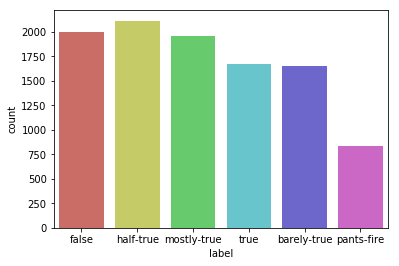

In [31]:
check_dist(traindata)

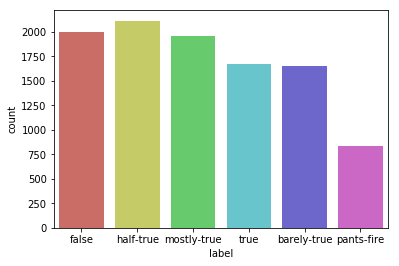

In [32]:
check_dist(valdata)

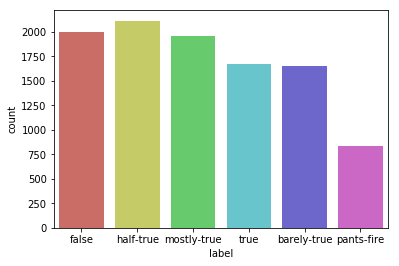

In [33]:
check_dist(testdata)

In [34]:
# check for missing labels
def check_missLabel(dataset):
#   dataset.info()
  print("Missing label values in {} are {}".format(dataset.name,dataset['label'].isnull().sum()))
  print("----------------------------------------------------------------")
check_missLabel(traindata)
check_missLabel(valdata)
check_missLabel(testdata)

Missing label values in Training Data are 0
----------------------------------------------------------------
Missing label values in Validation Data are 0
----------------------------------------------------------------
Missing label values in Testing Data are 0
----------------------------------------------------------------


In [0]:
# concatenate validation data with training data
traindata = pd.concat([valdata])

In [0]:
# stemming
# def stemming(tokens, stemmer):
#   stemmed = []
#   for token in tokens:
#     stemmed.append(stemmer.stem(token))
#   return stemmed

# def process_dataset(dataset, stopword=True):
#   tokens = [x.lower() for x in dataset]
#   stemmed_tokens = stemming(tokens, eng_stemmer)
#   stemmed_tokens = [x for x in stemmed_tokens if x not in stopwords]
#   return stemmed_tokens

In [0]:
# merge 'statement' and 'justification' columns
traindata['new'] = traindata['statement'].map(str) + traindata['justification'].map(str)
# testdata['new'] = testdata['statement'].map(str) + testdata['justification'].map(str)

In [38]:
traindata['new'].iloc[0:1].values

array(['We have less Americans working now than in the 70s.However, Hartzler was talking about the entire decade of the 70s. The first eight years of the decade, 1970 through 1977, have a lower employment-population ratio and a lower labor force participation rate than 2015.'],
      dtype=object)

**Feature extraction (vectorization) :** Build Bag-Of-Words model using CountVectorizer and TfidfVectorizer. 






In [39]:
# Convert text to word count vectors with CountVectorizer
# create the transform
cvec = CountVectorizer()

# tokenize, build vocab and encode training data
traindata_cvec = cvec.fit_transform(traindata['new'].values)

# summarize
print(cvec.vocabulary_)
# print(cvec.get_feature_names())

{'we': 9447, 'have': 4160, 'less': 5141, 'americans': 710, 'working': 9605, 'now': 5977, 'than': 8725, 'in': 4483, 'the': 8739, '70s': 323, 'however': 4354, 'hartzler': 4146, 'was': 9419, 'talking': 8619, 'about': 413, 'entire': 3203, 'decade': 2501, 'of': 6051, 'first': 3619, 'eight': 3073, 'years': 9645, '1970': 104, 'through': 8802, '1977': 110, 'lower': 5297, 'employment': 3143, 'population': 6653, 'ratio': 7087, 'and': 733, 'labor': 4985, 'force': 3704, 'participation': 6338, 'rate': 7079, '2015': 153, 'when': 9510, 'obama': 6006, 'sworn': 8584, 'into': 4684, 'office': 6063, 'he': 4176, 'did': 2715, 'not': 5961, 'use': 9224, 'holy': 4301, 'bible': 1214, 'but': 1499, 'instead': 4631, 'kuran': 4975, 'their': 8745, 'equivalency': 3235, 'to': 8836, 'our': 6175, 'very': 9291, 'different': 2724, 'beliefs': 1167, 'ellison': 3108, 'used': 9225, 'koran': 4960, 'that': 8730, 'once': 6098, 'belonged': 1175, 'thomas': 8780, 'jefferson': 4801, 'borrowing': 1344, 'rare': 7076, 'book': 1325, 'fr

says': 9676, 'the': 10988, 'annies': 1044, 'list': 6639, 'political': 8376,

In [40]:
# summarize encoded vector
print(traindata_cvec.shape)
print(type(traindata_cvec))
print(traindata_cvec.toarray())

(1284, 9690)
<class 'scipy.sparse.csr.csr_matrix'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [0]:
# Calculate inverse document frequencies
# create the transform
tfidf_vec = TfidfTransformer()

# tokenize, build vocab and encode training data
traindata_tfidf_vec = tfidf_vec.fit_transform(traindata_cvec)

In [42]:
# tfidf score
tfidf_vec.transform(traindata_cvec)

<1284x9690 sparse matrix of type '<class 'numpy.float64'>'
	with 75478 stored elements in Compressed Sparse Row format>

In [43]:
# summarize encoded vector
print(traindata_tfidf_vec.shape)
print(traindata_tfidf_vec.toarray())

(1284, 9690)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
# tfidf + ngrams
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), use_idf=True, smooth_idf=True)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(traindata['new'].values)

In [45]:
# print(tfidf_ngram.toarray())
# tfidf.vocabulary_
first_vector_tfidfvectorizer = tfidf_vectorizer_vectors[0]


# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)
 

,tfidf
70s,0.328225
decade,0.242670
lower,0.191335
70s years,0.164112
70s hartzler,0.164112
lower labor,0.164112
talking entire,0.164112
hartzler,0.164112
ratio lower,0.164112
1977 lower,0.164112


In [46]:
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [0]:
# POS tagging using CRF
tagged_sentence = nltk.corpus.treebank.tagged_sents(tagset='universal')
# print(len(tagged_sentence))

In [0]:
# load training sentences
training_sentences = traindata['new']
# print(training_sentences)

In [0]:
# function to extract features from dataset
def features(sentence, index):
  #returns a dictionary containing extracted features
  return {
      'is_first_capital': int(sentence[index][0].isupper()),
      'is_first_word': int(index==0),
      'is_last_word': int(index==len(sentence)-1),
      'is_complete_capital': int(sentence[index].upper()==sentence[index]),
      'is_complete_lower': int(sentence[index].lower()==sentence[index]),
      'prev_word':'' if index==0 else sentence[index-1],
      'next_word':'' if index==len(sentence)-1 else sentence[index+1],
      'is_numeric': int(sentence[index].isdigit()),
      'is_alphanumeric': int(bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])',sentence[index])))),
      'prefix_1': sentence[index][0],
      'prefix_2': sentence[index][:2],
      'prefic_3': sentence[index][:3],
      'prefix_4': sentence[index][:4],
      'suffix_1': sentence[index][-1],
      'suffix_2': sentence[index][-2:],
      'suffix_3': sentence[index][-3:],
      'suffix_4': sentence[index][-4:],
      'word_has_hyphen': 1 if '-' in sentence[index] else 0
  }

In [0]:
# function to strip tags from tagged corpus
def untag(sentence):
  return [word for word,tag in sentence]

In [0]:
# # download GloVe word embeddings file
# !wget http://nlp.stanford.edu/data/glove.6B.zip

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')


In [0]:
# extract the zip file at drive
# import zipfile
# zip_ref = zipfile.ZipFile("glove.6B.zip", 'r')
# zip_ref.extractall('content/drive/')
# zip_ref.close()

In [0]:
# load GloVe pretrained vectors from glove.6B.50d.txt
# with open("content/drive/glove.6B.50d.txt", "rb") as lines:
#   w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
#         for line in lines}

In [0]:
# print(len(w2v))

In [0]:
# w2v
# now we can use the above dictionary to build features. The simplest way to do that is by averaging word vectors for all words in a text.
# # I will build a sklearn compatible transformer that is initalised with a word-> vector dictionary
# class MeanEmbeddingVectorizer(object):
#   def __init__(self, word2vec):
#     self.word2vec = word2vec
#     # if a text is empty, return a vector of zeros with same dimensions
#     self.dim = len(word2vec.iteravalues.next())
    
  
#   def fit(self, X, y):
#     return self
  
#   def transform(self, X):
#     return np.array([
#         np.mean([self.word2vec[w] for w in words if w in self.word2vec]
#                 or [np.zeros(self.dim)], axis=0)
#         for words in X
#     ])
    

**Task: Six-way classification**

Training models with word-count-vectors from CountVectorizer method.

In [0]:
# using LogisticRegression
logReg_pipeline_cv = Pipeline([
    ('LogRCV', cvec),
    ('LogR_model', LogisticRegression())
])

logReg_pipeline_cv.fit(traindata['new'], traindata['label'])
predictions_logReg = logReg_pipeline_cv.predict(testdata['statement'])
logReg_cv = np.mean(predictions_logReg == testdata['label'])

# using SVM
svm_pipeline_cv = Pipeline([
    ('svmCV', cvec),
    ('svm_model', svm.LinearSVC())
])

svm_pipeline_cv.fit(traindata['new'], traindata['label'])
predictions_svm = svm_pipeline_cv.predict(testdata['statement'])
svm_cv = np.mean(predictions_svm == testdata['label'])

# using naive bayes
nb_pipeline_cv = Pipeline([
    ('nbCV', cvec),
    ('nb_model', MultinomialNB())
])

nb_pipeline_cv.fit(traindata['new'], traindata['label'])
predictions_nb = nb_pipeline_cv.predict(testdata['statement'])
nb_cv = np.mean(predictions_nb == testdata['label'])

# using random forest
rf_pipeline_cv = Pipeline([
    ('rfCV', cvec),
    ('rf_model', RandomForestClassifier(n_estimators=400, n_jobs=4))
])

rf_pipeline_cv.fit(traindata['new'], traindata['label'])
predictions_rf = rf_pipeline_cv.predict(testdata['statement'])
rf_cv = np.mean(predictions_rf == testdata['label'])

In [56]:
print(logReg_cv)
print(svm_cv)
print(nb_cv)
print(rf_cv)

0.1894238358326756
0.19021310181531176
0.20757695343330704
0.17205998421468036


In [0]:
def kFoldCV(model):
  k_fold = KFold(n_splits=5)
  scores = []
  conf_matrix = np.zeros(shape=(6,6))
  
  for train_index, test_index in k_fold.split(traindata['new']):
    trainText = traindata.iloc[train_index]['new']
    train_y = traindata.iloc[train_index]['label']
    
    testText = traindata.iloc[test_index]['new']
    test_y = traindata.iloc[test_index]['label']
    
    model.fit(trainText, train_y)
    pred_y = model.predict(testText)
    
    conf_matrix += confusion_matrix(test_y, pred_y)
    scores.append(f1_score(test_y, pred_y, average='micro'))
    
  return (print('Total statements classified:', len(traindata)),
         print('Score:', sum(scores)/len(scores)),
         print('Confusion Matrix:'),
         print(conf_matrix),
         print("---------------------------------------------------"))

In [58]:
kFoldCV(logReg_pipeline_cv)
kFoldCV(svm_pipeline_cv)
kFoldCV(nb_pipeline_cv)
kFoldCV(rf_pipeline_cv)

Total statements classified: 1284
Score: 0.2679322714007782
Confusion Matrix:
[[69. 54. 38. 45.  9. 22.]
 [65. 64. 41. 49. 21. 23.]
 [41. 43. 82. 57.  4. 21.]
 [46. 42. 47. 81.  7. 28.]
 [17. 46. 11. 21. 12.  9.]
 [23. 44. 27. 35.  4. 36.]]
---------------------------------------------------
Total statements classified: 1284
Score: 0.25546267023346303
Confusion Matrix:
[[66. 50. 40. 43. 15. 23.]
 [69. 60. 38. 43. 26. 27.]
 [53. 39. 69. 54.  7. 26.]
 [46. 44. 45. 77. 11. 28.]
 [18. 40. 11. 23. 19.  5.]
 [25. 37. 24. 39.  7. 37.]]
---------------------------------------------------
Total statements classified: 1284
Score: 0.25624696011673154
Confusion Matrix:
[[ 44.  69.  66.  54.   0.   4.]
 [ 49.  91.  50.  70.   0.   3.]
 [ 31.  49.  80.  83.   0.   5.]
 [ 27.  49.  61. 109.   0.   5.]
 [ 11.  51.  26.  24.   1.   3.]
 [ 18.  34.  47.  65.   1.   4.]]
---------------------------------------------------
Total statements classified: 1284
Score: 0.28896522373540856
Confusion Matrix:
[[ 7

(None, None, None, None, None)

Training models with word-count-vectors from TfidfVectorizer method.

In [0]:
# using LogisticRegression
logReg_pipeline_ngram = Pipeline([
    ('LogR_tfidf', tfidf_vectorizer),
    ('LogR_model', LogisticRegression())
])

logReg_pipeline_ngram.fit(traindata['new'], traindata['label'])
predictions_logReg_ngram = logReg_pipeline_ngram.predict(testdata['statement'])
logReg_ngram = np.mean(predictions_logReg_ngram == testdata['label'])

# using SVM
svm_pipeline_ngram = Pipeline([
    ('svmCV', tfidf_vectorizer),
    ('svm_model', svm.LinearSVC())
])

svm_pipeline_ngram.fit(traindata['new'], traindata['label'])
predictions_svm = svm_pipeline_ngram.predict(testdata['statement'])
svm_ngram = np.mean(predictions_svm == testdata['label'])

# using naive bayes
nb_pipeline_ngram = Pipeline([
    ('nbCV', tfidf_vectorizer),
    ('nb_model', MultinomialNB())
])

nb_pipeline_ngram.fit(traindata['new'], traindata['label'])
predictions_nb = nb_pipeline_ngram.predict(testdata['statement'])
nb_ngram = np.mean(predictions_nb == testdata['label'])

# using random forest
rf_pipeline_ngram = Pipeline([
    ('rfCV', tfidf_vectorizer),
    ('rf_model', RandomForestClassifier(n_estimators=400, n_jobs=4))
])

rf_pipeline_ngram.fit(traindata['new'], traindata['label'])
predictions_rf = rf_pipeline_ngram.predict(testdata['statement'])
rf_ngram = np.mean(predictions_rf == testdata['label'])

In [60]:
print(logReg_ngram)
print(svm_ngram)
print(nb_ngram)
print(rf_ngram)

0.22336227308603
0.1941594317284925
0.22573007103393844
0.18468823993685873


In [61]:
kFoldCV(logReg_pipeline_ngram)
kFoldCV(svm_pipeline_ngram)
kFoldCV(nb_pipeline_ngram)
kFoldCV(rf_pipeline_ngram)

Total statements classified: 1284
Score: 0.26560372081712064
Confusion Matrix:
[[ 35. 102.  49.  50.   0.   1.]
 [ 32. 122.  36.  72.   0.   1.]
 [ 23.  66.  79.  79.   0.   1.]
 [ 20.  71.  56. 104.   0.   0.]
 [  8.  67.  13.  28.   0.   0.]
 [ 16.  48.  42.  62.   0.   1.]]
---------------------------------------------------
Total statements classified: 1284
Score: 0.2640381809338522
Confusion Matrix:
[[55. 67. 48. 44.  4. 19.]
 [50. 84. 37. 64.  6. 22.]
 [37. 43. 76. 71.  1. 20.]
 [28. 49. 55. 96.  2. 21.]
 [13. 44. 18. 25. 13.  3.]
 [28. 37. 41. 47.  1. 15.]]
---------------------------------------------------
Total statements classified: 1284
Score: 0.2648133511673152
Confusion Matrix:
[[ 22. 104.  56.  55.   0.   0.]
 [ 21. 134.  38.  70.   0.   0.]
 [ 16.  71.  82.  79.   0.   0.]
 [ 10.  81.  58. 102.   0.   0.]
 [  6.  72.  15.  23.   0.   0.]
 [ 10.  54.  41.  64.   0.   0.]]
---------------------------------------------------
Total statements classified: 1284
Score: 0.28272

(None, None, None, None, None)

**Task: Binary Classification**

In [0]:
# function to convert 6 classes of label into 2 classes
# def classLabel(dataset):
#   for index in range(len(dataset['label'])):
#     if(dataset.iloc[index]['label'] == 'true' or dataset.iloc[index]['label'] == 'mostly-true' or dataset.iloc[index]['label'] == 'half-true'):
#       dataset.iloc[index]['label'] = 'true'
      
#     if(dataset.iloc[index]['label'] == 'barely-true' or dataset.iloc[index]['label'] == 'false' or dataset.iloc[index]['label'] == 'pants-fire'):
#       dataset.iloc[index]['label'] = 'false'
      
#   return dataset

In [0]:
# load dataset containing only two classes of label
new_train = pd.read_csv('newtrain.csv')
new_test = pd.read_csv('newtest.csv')
new_val = pd.read_csv('newvalid.csv')

In [64]:
new_test.head()

,Statement,Label
0,Building a wall on the U.S.-Mexico border will...,True
1,Wisconsin is on pace to double the number of l...,False
2,Says John McCain has done nothing to help the ...,False
3,Suzanne Bonamici supports a plan that will cut...,True
4,When asked by a reporter whether hes at the ce...,False


In [0]:
# concatenate validation set with training dataset
new_train = pd.concat([new_val])

# drop Null rows
new_train = new_train.dropna()

In [75]:
new_train.head()

,Statement,Label
0,We have less Americans working now than in the...,FALSE
1,"When Obama was sworn into office, he DID NOT u...",FALSE
2,Says Having organizations parading as being so...,FALSE
3,Says nearly half of Oregons children are poor.,TRUE
4,On attacks by Republicans that various program...,TRUE


**Feature extraction (vectorization) :** Build Bag-Of-Words model using CountVectorizer and TfidfVectorizer. 






In [66]:
# Convert text to word count vectors with CountVectorizer
# create the transform
cvec = CountVectorizer()

# tokenize, build vocab and encode training data
traindata_cvec = cvec.fit_transform(new_train['Statement'].values)

# summarize
print(cvec.vocabulary_)
# print(cvec.get_feature_names())

{'we': 4222, 'have': 1894, 'less': 2342, 'americans': 346, 'working': 4298, 'now': 2729, 'than': 3913, 'in': 2044, 'the': 3922, '70s': 158, 'when': 4247, 'obama': 2746, 'was': 4208, 'sworn': 3844, 'into': 2126, 'office': 2766, 'he': 1900, 'did': 1247, 'not': 2724, 'use': 4118, 'holy': 1963, 'bible': 565, 'but': 698, 'instead': 2106, 'kuran': 2272, 'their': 3924, 'equivalency': 1466, 'to': 3962, 'our': 2824, 'very': 4141, 'different': 1255, 'beliefs': 548, 'says': 3474, 'having': 1896, 'organizations': 2815, 'parading': 2875, 'as': 420, 'being': 547, 'social': 3649, 'welfare': 4236, 'and': 355, 'then': 3927, 'involved': 2144, 'political': 3013, 'combat': 921, 'harkens': 1883, 'back': 476, 'why': 4261, 'statute': 3746, 'hundred': 1992, 'years': 4316, 'ago': 290, 'said': 3445, 'that': 3916, 'they': 3932, 'were': 4240, 'prohibited': 3113, 'nearly': 2677, 'half': 1870, 'of': 2758, 'oregons': 2812, 'children': 832, 'are': 402, 'poor': 3024, 'on': 2778, 'attacks': 442, 'by': 702, 'republicans

In [0]:
# Calculate inverse document frequencies
# create the transform
tfidf_vec = TfidfTransformer()

# tokenize, build vocab and encode training data
traindata_tfidf_vec = tfidf_vec.fit_transform(traindata_cvec)

In [68]:
# tfidf score
tfidf_vec.transform(traindata_cvec)

<2569x4335 sparse matrix of type '<class 'numpy.float64'>'
	with 41473 stored elements in Compressed Sparse Row format>

In [0]:
# tfidf + ngrams
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(new_train['Statement'].values)

In [0]:
# using LogisticRegression
logReg_pipeline_cv = Pipeline([
    ('LogRCV', cvec),
    ('LogR_model', LogisticRegression())
])

logReg_pipeline_cv.fit(new_train['Statement'], new_train['Label'])
predictions_logReg = logReg_pipeline_cv.predict(new_test['Statement'])
logReg_cv = np.mean(predictions_logReg == new_test['Label'])

# using SVM
svm_pipeline_cv = Pipeline([
    ('svmCV', cvec),
    ('svm_model', svm.LinearSVC())
])

svm_pipeline_cv.fit(new_train['Statement'], new_train['Label'])
predictions_svm = svm_pipeline_cv.predict(new_test['Statement'])
svm_cv = np.mean(predictions_svm == new_test['Label'])

# using naive bayes
nb_pipeline_cv = Pipeline([
    ('nbCV', cvec),
    ('nb_model', MultinomialNB())
])

nb_pipeline_cv.fit(new_train['Statement'], new_train['Label'])
predictions_nb = nb_pipeline_cv.predict(new_test['Statement'])
nb_cv = np.mean(predictions_nb == new_test['Label'])

# using random forest
rf_pipeline_cv = Pipeline([
    ('rfCV', cvec),
    ('rf_model', RandomForestClassifier(n_estimators=400, n_jobs=4))
])

rf_pipeline_cv.fit(new_train['Statement'], new_train['Label'])
predictions_rf = rf_pipeline_cv.predict(new_test['Statement'])
rf_cv = np.mean(predictions_rf == new_test['Label'])

In [72]:
print(logReg_cv)
print(svm_cv)
print(nb_cv)
print(rf_cv)
# new_predictions_logReg

0.0
0.0
0.0
0.0


In [0]:
# using LogisticRegression
logReg_pipeline_cv = Pipeline([
    ('LogRCV', tfidf_vectorizer),
    ('LogR_model', LogisticRegression())
])

logReg_pipeline_cv.fit(new_train['Statement'], new_train['Label'])
predictions_logReg = logReg_pipeline_cv.predict(new_test['Statement'])
logReg_ngram = np.mean(predictions_logReg == new_test['Label'])

# using SVM
svm_pipeline_cv = Pipeline([
    ('svmCV', tfidf_vectorizer),
    ('svm_model', svm.LinearSVC())
])

svm_pipeline_cv.fit(new_train['Statement'], new_train['Label'])
predictions_svm = svm_pipeline_cv.predict(new_test['Statement'])
svm_ngram = np.mean(predictions_svm == new_test['Label'])

# using naive bayes
nb_pipeline_cv = Pipeline([
    ('nbCV', tfidf_vectorizer),
    ('nb_model', MultinomialNB())
])

nb_pipeline_cv.fit(new_train['Statement'], new_train['Label'])
predictions_nb = nb_pipeline_cv.predict(new_test['Statement'])
nb_ngram = np.mean(predictions_nb == new_test['Label'])

# using random forest
rf_pipeline_cv = Pipeline([
    ('rfCV', tfidf_vectorizer),
    ('rf_model', RandomForestClassifier(n_estimators=400, n_jobs=4))
])

rf_pipeline_cv.fit(new_train['Statement'], new_train['Label'])
predictions_rf = rf_pipeline_cv.predict(new_test['Statement'])
rf_ngram = np.mean(predictions_rf == new_test['Label'])

In [74]:
print(logReg_ngram)
print(svm_ngram)
print(nb_ngram)
print(rf_ngram)

0.0
0.0
0.0
0.0
